In [3]:
import pandas as pd
import random

# Crear una lista de tipos de fuentes
fuentes = []
n = 125

# 50 fuentes de lagos o ríos
for _ in range(50):
    fuentes.append(('Lago o Río', 0.37))

# 40 fuentes de aguas subterráneas
for _ in range(40):
    fuentes.append(('Aguas Subterráneas', 0.48))

# 15 fuentes de tratamiento de aguas residuales
for _ in range(15):
    energia = round(random.uniform(0.62, 0.87), 2)
    fuentes.append(('Tratamiento Aguas Residuales', energia))

# 10 fuentes de reutilización de aguas residuales
for _ in range(10):
    energia = round(random.uniform(1.0, 2.5), 2)
    fuentes.append(('Reutilización Aguas Residuales', energia))

# 10 fuentes del mar (desalinización)
for _ in range(10):
    energia = round(random.uniform(2.58, 8.5), 2)
    fuentes.append(('Mar (Desalinización)', energia))

# Asignar un ID a cada fuente
fuentes_data = {
    'id_fuente': range(1, 126),
    'tipo_fuente': [f[0] for f in fuentes],
    'energia_por_litro': [f[1] for f in fuentes]
}

# Crear un DataFrame
fuentes_df = pd.DataFrame(fuentes_data)

# Guardar en un archivo CSV
fuentes_df.to_csv('fuentes_energia_por_litro.csv', index=False)

print(fuentes_df.head())  # Imprimir las primeras filas del archivo


   id_fuente tipo_fuente  energia_por_litro
0          1  Lago o Río               0.37
1          2  Lago o Río               0.37
2          3  Lago o Río               0.37
3          4  Lago o Río               0.37
4          5  Lago o Río               0.37


In [4]:
# Abrimos el archivo data/comunas.csv
comunas = pd.read_csv('data/comunas.csv')

# Agregamos la columna de porcentaje_regional
# Es el porcentaje de la población de la comuna con respecto a la región
comunas['porcentaje_regional'] = comunas['poblacion'] / comunas['poblacion'].sum()

# Guardamos el archivo con la nueva columna
comunas.to_csv('data/comunas.csv', index=False)

## Generar demanda de agua por fuente

In [11]:

import pandas as pd
import random

# Cargar el archivo subido fuentes_existentes_por_comuna.csv y el archivo con la población por comuna
fuentes_existentes_df = pd.read_csv('data/fuentes_existentes_por_comuna.csv')

comunas_df = pd.read_csv('data/comunas.csv')

poblacion_df = comunas_df[['id_comuna', 'poblacion']]

# Unir el dataframe de fuentes con el de población para agregar la columna de población por comuna
fuentes_existentes_df = fuentes_existentes_df.merge(poblacion_df, on='id_comuna', how='left')

# Generar un valor aleatorio entre 110 y 140 litros por persona por cada fuente
fuentes_existentes_df['consumo_diario_por_persona'] = [random.randint(110, 140) for _ in range(len(fuentes_existentes_df))]

# Contar la cantidad de fuentes por comuna para distribuir la demanda
fuentes_por_comuna = fuentes_existentes_df.groupby('id_comuna')['id_fuente'].transform('count')

# Calcular la demanda de agua por cada fuente, distribuyendo la demanda total de la comuna entre las fuentes
fuentes_existentes_df['demanda_agua'] = (fuentes_existentes_df['poblacion'] * fuentes_existentes_df['consumo_diario_por_persona']) // fuentes_por_comuna

# Eliminar la columna 'consumo_diario_por_persona' ya que solo era para cálculo
# fuentes_existentes_df.drop(columns=['consumo_diario_por_persona'], inplace=True)

# Guardar el archivo actualizado con la nueva columna de demanda de agua distribuida por fuente
output_file_path = 'fuentes_existentes_con_demanda_agua_realista.csv'
fuentes_existentes_df.to_csv(output_file_path, index=False)

# Mostrar las primeras filas del dataframe actualizado
fuentes_existentes_df.head()


,id_fuente,id_comuna,poblacion,consumo_diario_por_persona,demanda_agua
0,1,1,245347,123,10059227
1,2,1,245347,134,10958832
2,3,1,245347,129,10549921
3,4,2,83009,127,3514047
4,5,2,83009,112,3099002


## Generamos cantidad maxima de generadores por comuna

In [21]:
# Reimportar las librerías necesarias
import pandas as pd

# Cargar los archivos subidos: fuentes_existentes_por_comuna.csv y generadores.csv
fuentes_existentes_path = 'data/fuentes_existentes_por_comuna.csv'
generadores_path = 'data/generadores.csv'

# Leer los archivos
fuentes_existentes_df = pd.read_csv(fuentes_existentes_path)
generadores_df = pd.read_csv(generadores_path)

# Tasa promedio de energía por litro (kWh/L)
energia_por_litro = 0.37  # Basado en una fuente promedio como ríos o lagos

# Calcular el total de kWh necesarios para cada comuna en función de la demanda de agua
fuentes_existentes_df['energia_total_kwh'] = fuentes_existentes_df['demanda_agua'] * (energia_por_litro / (24 * 30))

# Inicializar una lista para almacenar el resultado
max_generadores = []

# Calcular el número máximo de generadores por tipo para cada comuna
for index, row in fuentes_existentes_df.iterrows():
    id_comuna = row['id_comuna']
    energia_total = row['energia_total_kwh']  # Energía total en kWh para esa comuna
    
    # Para cada tipo de generador (solar, gasolina, diésel)
    for _, gen_row in generadores_df.iterrows():
        id_generador = gen_row['id_generador']
        capacidad_generador = gen_row['capacidad']  # Capacidad del generador en kW
        
        # Calcular el número máximo de generadores necesarios para suplir la demanda de la comuna
        max_generadores_necesarios = energia_total / capacidad_generador
        max_generadores.append((id_generador, int(id_comuna), int(max_generadores_necesarios)))

# Crear el DataFrame
max_generadores_df = pd.DataFrame(max_generadores, columns=['id_generador', 'id_comuna', 'max_generators'])

# Guardar en CSV
file_path = 'max_generadores_por_tipo_por_comuna.csv'
max_generadores_df.to_csv(file_path, index=False)

# Mostrar las primeras filas del DataFrame generado
max_generadores_df.head()


,id_generador,id_comuna,max_generators
0,1,1,103
1,2,1,51
2,3,1,25
3,1,1,112
4,2,1,56


In [22]:
# Imprimimos los nombres de los archivos en la carpeta data
import os

for file in os.listdir('data'):
    print(file)
    

comunas.csv
fuentes_energia_por_litro.csv
fuentes_existentes_por_comuna.csv
generadores.csv
generador_capacidades_por_ubicacion.csv
max_generadores_por_tipo_por_comuna.csv
ubicaciones_por_comuna.csv


### Jgs

In [ ]:
import pandas as pd
import random

# Definir el rango de id_ubicacion y los tipos de generadores
ubicaciones = range(1, 218)  # Desde 1 hasta 217
generadores = [1, 2, 3]  # Tipos de generadores (1: solar, 2: gasolina, 3: diésel)

# Definir las capacidades típicas de los generadores (en kW)
capacidades = {
    1: 50,   # Solar
    2: 100,  # Gasolina
    3: 200   # Diésel
}

# Generar la lista para id_generador, id_ubicacion y capacidad
generador_capacidades = []
for s in ubicaciones:
    for g in generadores:
        capacidad = capacidades[g]
        generador_capacidades.append((g, s, capacidad))

# Crear un DataFrame con los resultados
generador_capacidades_df = pd.DataFrame(generador_capacidades, columns=['id_generador', 'id_ubicacion', 'capacidad'])

# Guardar el archivo CSV
file_path = 'generador_capacidades_por_ubicacion.csv'
generador_capacidades_df.to_csv(file_path, index=False)

# Mostrar las primeras filas del archivo
generador_capacidades_df.head()


### Representacion Mapa Calor

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
mapa_chile = gpd.read_file("ShapeFiles\Comunas\comunas.shp")

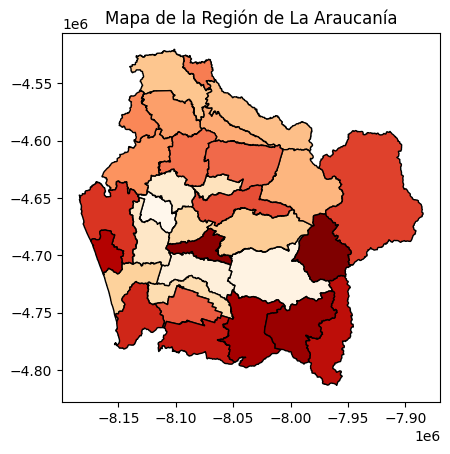

In [27]:
mapa_araucania = mapa_chile[mapa_chile['Region'] == 'Región de La Araucanía']

mapa_araucania.plot(cmap='OrRd', edgecolor='black')
plt.title("Mapa de la Región de La Araucanía")
plt.show()

#### Densidad poblacional

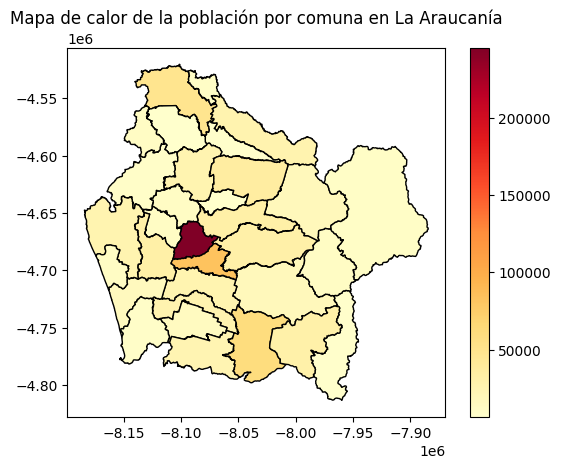

In [28]:
poblacion = pd.read_csv("data/comunas.csv")
mapa_araucania = mapa_araucania.merge(poblacion, left_on='Comuna', right_on='nombre_comuna')
mapa_araucania.plot(column='poblacion', cmap='YlOrRd', legend=True, edgecolor='black')
plt.title("Mapa de calor de la población por comuna en La Araucanía")
plt.show()


In [29]:
mapa_araucania.head()

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry,id_comuna,id_provincia,nombre_provincia,nombre_comuna,poblacion,porcentaje_regional
0,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644....",26,1,Cautín,Cholchol,12427,0.013027
1,79,279935.999530,23,11,9103,9,3.127305e+09,360052.118714,Región de La Araucanía,Cunco,Cautín,"POLYGON ((-7992286.596 -4690011.549, -7992280....",16,1,Cautín,Cunco,18065,0.018937
2,81,213151.717476,23,11,9105,9,1.449626e+09,250988.103082,Región de La Araucanía,Freire,Cautín,"POLYGON ((-8072011.778 -4703188.965, -8072009....",9,1,Cautín,Freire,25472,0.026702
3,82,142385.870502,22,11,9106,9,9.259368e+08,181788.380218,Región de La Araucanía,Galvarino,Cautín,"POLYGON ((-8101637.233 -4624861.526, -8101628....",22,1,Cautín,Galvarino,12623,0.013233
4,87,176551.420831,23,11,9111,9,1.205041e+09,226006.583751,Región de La Araucanía,Nueva Imperial,Cautín,"POLYGON ((-8113223.19 -4674806.372, -8113141.4...",5,1,Cautín,Nueva Imperial,32510,0.034080


#### Distribucion de generadores

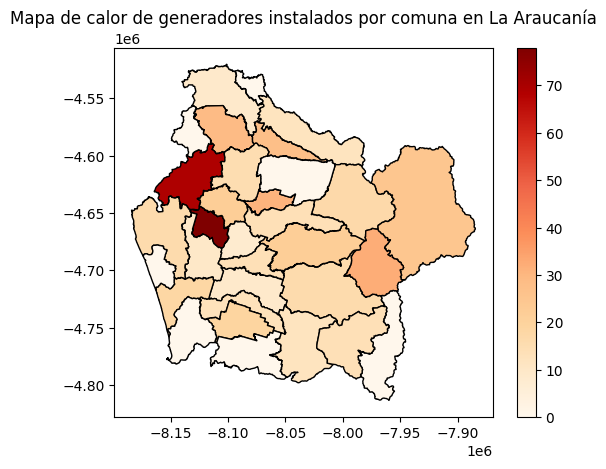

In [31]:
# Cargar el CSV con la distribución de generadores
generadores = pd.read_csv("output/distribucion_generadores_por_comuna.csv")

# Unir el shapefile con el CSV de generadores en base a 'id_comuna'
mapa_araucania = mapa_araucania.merge(generadores, on='id_comuna', how='left')

# Crear un mapa de calor basado en la columna 'cantidad_generadores'
mapa_araucania.plot(column='cantidad_generadores', cmap='OrRd', legend=True, edgecolor='black')

# Agregar un título
plt.title("Mapa de calor de generadores instalados por comuna en La Araucanía")
plt.show()

### Fuentes de agua en Chile

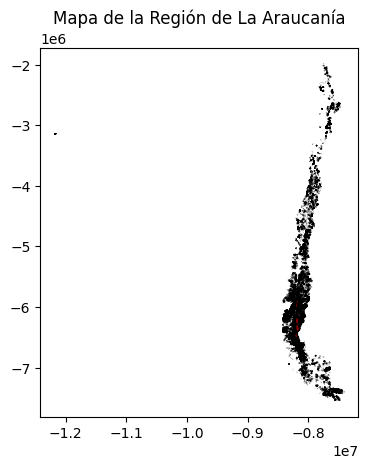

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el shapefile de la región de La Araucanía
mapa_chile = gpd.read_file("Masas_Lacustres\masas_lacustres.shp")

# Opcional: Puedes filtrar por la región de La Araucanía si el shapefile contiene todas las regiones de Chile
# mapa_araucania = mapa_chile[mapa_chile['Region'] == 'Región de La Araucanía']

# Graficar el mapa
mapa_chile.plot(cmap='OrRd', edgecolor='black')
plt.title("Mapa de la Región de La Araucanía")
plt.show()